# Predict climate from berry fungal communities

> using `ritme` (https://github.com/adamovanja/ritme)

note. use the **ritme_model** environment! 


In [8]:
from ritme.find_best_model_config import (
    _load_experiment_config,
    _load_phylogeny,
    _load_taxonomy,
    find_best_model_config,
    save_best_models,
)
from ritme.split_train_test import _load_data, split_train_test
from ritme.evaluate_tuned_models import evaluate_tuned_models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mlflow
import numpy as np
import os

from sklearn.metrics import r2_score

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries


In [10]:
# set experiment configuration path - this is downloaded from the github repo

# no groups 
#model_config_path = "/home/lfloerl/microterroir/Microbiome/Other_scripts/config/RITMEconfig_Temp_noGroup.json"

# by year 
#model_config_path = "/home/lfloerl/microterroir/Microbiome/Other_scripts/config/RITMEconfig_Temp_byYear.json"

# restricted seach space but all models 
model_config_path = "/home/lfloerl/microterroir/Microbiome/Other_scripts/config/RITMEconfig_Temp_WithParams.json"


# define path to feature table, metadata, and taxonomy (no phylogeny)
path_to_ft = "climate_filtered_table.qza"
path_to_md = "/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Climate.tsv"
path_to_tax = "/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy.qza"

# define train size
train_size = 0.8

# if you want to store the best models, define path where you want to store
path_to_store_best_models = "Temp_byYear_best_models"

In [11]:
config = _load_experiment_config(model_config_path)

## Read & split data


In [12]:
md, ft = _load_data(path_to_md, path_to_ft)
print(md.shape, ft.shape)

(595, 36) (326, 6091)


In [13]:
train_val, test = split_train_test(
    md,
    ft,
    group_by_column=config["group_by_column"],
    train_size=train_size,
    seed=config["seed_data"],
)

Train: (260, 6127), Test: (66, 6127)


/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/split_train_test.py:139: UserWarning: Provided feature table contains absolute instead of relative abundances. Hence, converting it to relative abundances...
  warnings.warn(


## Find best model config

View the results with navigating to the folder in the terminal (e.g. `cd /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_all_models`) and launching  mlflow (`mlflow ui --port 8080`) and opening _http://localhost:8080_ 


**Try different configs** (`experiment_tag`)
* `all_models_noGroup` --> Train: (260, 6127), Test: (66, 6127)
    * "linreg", "xgb", "rf" 
    * no grouping, seed 14 (larger test set)
    * test_mode = true (use entire search space)

* `ritme_Temp_byYear` --> Train: (278, 6127), Test: (48, 6127)
    * "linreg", "xgb", "rf" 
    * split train/test by 'Year', seed 14 (larger test set)
    * test_mode = true (use entire search space)

* `ritme_Temp_byYear_restrictedSpace`
    * restrict search space for XGB model (only 100 trials)


In [ ]:
tax = _load_taxonomy(path_to_tax)

best_model_dict, path_to_exp = find_best_model_config(
    config, train_val, tax, path_store_model_logs="ritme_Temp_byYear_restrictedSpace_9")

2025-02-28 12:47:22,089	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.782 s, which may be a performance bottleneck.
2025-02-28 12:47:22,091	WARNING util.py:201 -- The `process_trial_result` operation took 0.784 s, which may be a performance bottleneck.
2025-02-28 12:47:22,092	WARNING util.py:201 -- Processing trial results took 0.785 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-28 12:47:22,092	WARNING util.py:201 -- The `process_trial_result` operation took 0.786 s, which may be a performance bottleneck.
2025-02-28 12:47:27,589	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.787 s, which may be a performance bottleneck.
2025-02-28 12:47:27,591	WARNING util.py:201 -- The `process_trial_result` operation took 0.788 s, which may be a performance bottleneck.
2025-02-28 12:47:27,591	WARNING util.py:201 -- Processing trial results took 0.789 s, which may be a performance bott

## Evaluate best models

**Key Metrics** for Model Assessment
1. Root Mean Square Error (RMSE)
    * Measures the standard deviation of the residuals (prediction errors)
    * Lower values indicate better performance
2. R-squared (R2)
    * Represents the proportion of variance in the dependent variable explained by the model
    * Higher values indicate better performance


We compare these metrics for the **training and test set** to 
* evaluate the model fit
* Detect overfitting: A significant discrepancy between training and test set performance can indicate overfitting. If the model performs much better on the training set than the test set, it may have memorized the training data rather than learning generalizable patterns
* Compare model stability: Consistent performance across both sets suggests a stable model that generalizes well

In [15]:
metrics = evaluate_tuned_models(best_model_dict, config, train_val, test)
metrics

/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/feature_space/aggregate_features.py:78: UserWarning: These features were not found in taxonomy and are hence disregarded: ['Fermentation_Timepoint'].
  warnings.warn(
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/feature_space/aggregate_features.py:78: UserWarning: These features were not found in taxonomy and are hence disregarded: ['Fermentation_Timepoint'].
  warnings.warn(
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/evaluate_models.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t = torch.tensor(transformed, dtype=torch.float32)
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/evaluate_models.py:176: UserWarning: To copy construct from a tensor, it is recommended to 

,rmse_train,r2_train,rmse_test,r2_test
linreg,0.284788,0.924234,0.612949,0.578352
xgb,0.641224,0.615891,0.642914,0.536119
nn_reg,0.406972,0.845274,0.599582,0.596541
rf,0.332605,0.896654,0.573071,0.631431


# Visualizations

In [22]:
# specify the location of the MLruns files 
log_folder_location = "/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_Temp_byYear_restrictedSpace_5/mlruns"

mlflow.set_tracking_uri(log_folder_location)

df_all_runs = mlflow.search_runs(
    order_by=["metrics.rmse_val ASC"], search_all_experiments=True)

In [17]:
# save output
#df_all_runs.to_csv('MLflow_output.csv')

In [18]:
df_metrics = df_all_runs[['tags.trial_name', "params.data_transform", "params.data_aggregation", "params.data_selection", "params.model", 'metrics.r2_train', 'metrics.rmse_train', 'metrics.r2_val', 'metrics.rmse_val' ]]
df_metrics.tail()

,tags.trial_name,params.data_transform,params.data_aggregation,params.data_selection,params.model,metrics.r2_train,metrics.rmse_train,metrics.r2_val,metrics.rmse_val
95,train_linreg_a8e068cf,pa,None,variance_ith,linreg,0.068704,1.003397,-0.044863,1.035840
96,train_linreg_495ce79a,ilr,tax_genus,variance_threshold,linreg,0.034272,1.021778,-0.048619,1.037701
97,train_linreg_4dceed8b,clr,tax_genus,abundance_quantile,linreg,0.954564,0.221630,-0.431294,1.212349
98,train_linreg_8b5fd3df,alr,tax_genus,variance_topi,linreg,0.121058,0.974786,-1.566544,1.623444
99,train_linreg_0f577121,alr,tax_genus,variance_topi,linreg,0.121940,0.974297,-1.584852,1.629225


/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


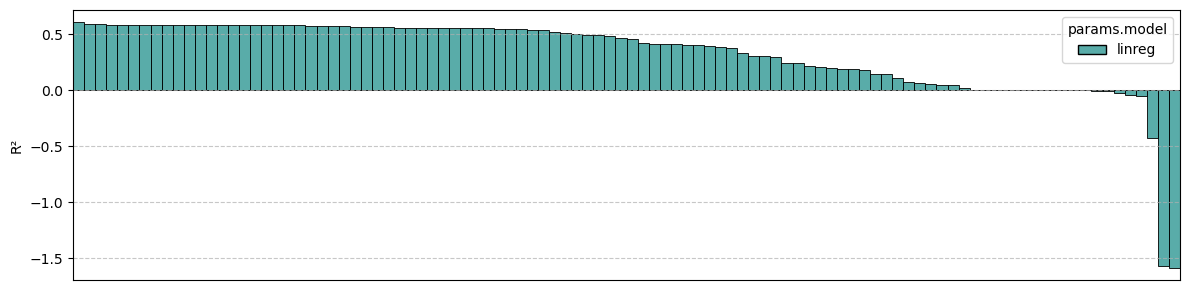

In [19]:
plt.figure(figsize=(12, 3))
sns.histplot(
    data=df_metrics,
    x=df_metrics.index,
    weights=df_metrics["metrics.r2_val"],
    bins=len(df_metrics),  
    hue=df_metrics["params.model"],
    #palette=model_colors,
    palette='viridis',
    element="bars",
    multiple="stack"  
)

plt.xlim(df_metrics.index.min(), df_metrics.index.max())
plt.xlabel("")
plt.ylabel("R²")
plt.xticks([], [])  # Hide x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show legend

plt.tight_layout()
#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RITME-test-R2.png', dpi=1000)
plt.show()

/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


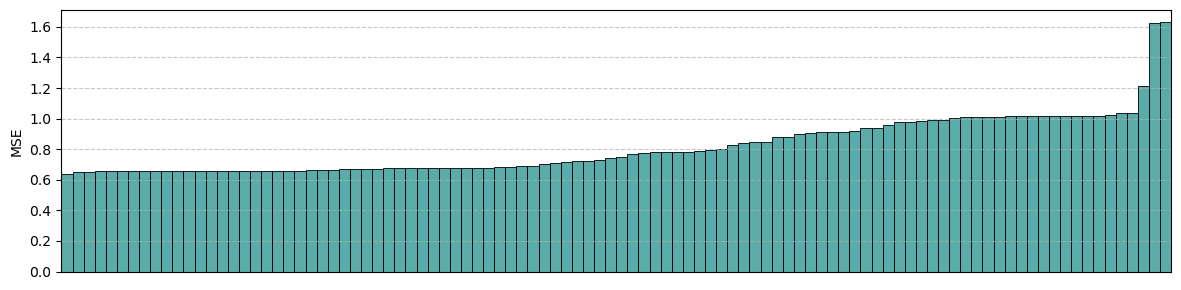

In [20]:
plt.figure(figsize=(12, 3))
sns.histplot(
    data=df_metrics,
    x=df_metrics.index,
    weights=df_metrics["metrics.rmse_val"],
    bins=len(df_metrics),  
    hue=df_metrics["params.model"],
    #palette=model_colors,
    palette='viridis',
    element="bars",
    multiple="stack"  
)

plt.xlim(df_metrics.index.min(), df_metrics.index.max())
plt.xlabel("")
plt.ylabel("MSE")
plt.xticks([], [])  # Hide x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RITME-test-MSE.png', dpi=1000)
plt.show()

# Extracting trained best models
Get best models for further usage

The best models are stored in Python dictionary best_model_dict with model_type as keys and TunedModel objects as values. To extract a given best model and perform predictions with it, see below code excerpt:

In [21]:
if path_to_store_best_models is not None:
    print(f"Saving best models to {path_to_store_best_models}...")
    if not os.path.exists(path_to_store_best_models):
        os.makedirs(path_to_store_best_models)

    save_best_models(best_model_dict, path_to_store_best_models)

Saving best models to Temp_byYear_best_models...


In [ ]:
# get best linreg model
best_linreg_model = best_model_dict["linreg"]
best_linreg_model

NameError: name 'best_model_dict' is not defined

In [ ]:
# perform prediction with best linreg model
test_predictions = best_linreg_model.predict(test, "test")
train_predictions = best_linreg_model.predict(train_val, "train")

In [ ]:
if path_to_store_best_models is not None:
    print(f"Saving best models to {path_to_store_best_models}...")
    if not os.path.exists(path_to_store_best_models):
        os.makedirs(path_to_store_best_models)

    save_best_models(best_model_dict, path_to_store_best_models)